<a href="https://colab.research.google.com/github/nanopiero/fusion/blob/main/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan d'expérience:

Régression

      - A.baseline radar cmls -> pluvios

Fusion, fusion multitâche

    - B.baseline radar + pluvio 1 min + cmls -> pluvios + cmls

    - C.tâches aux. 1.  A + tâche aux : -> val cml x masque segment x masque radar + val pluvio x masque pluvio x masque radar

    - D. tâches aux 2. tâche reconstruction PPI.
      - idée : f(radar[random_sample1], w) = y[70 x 64 x 64].  
         ft de coût : ||f(radar[random_sample1])[random_sample1_bar] - target ||
         + loss adversariale -> impossibilité de retrouver les indices renseignés

    - E. tâche aux 1 + tâche aux 2. A + (B) + c

Régression faiblement supervisée

    - E. introduction d'un bruit dans les CMLs et les pluvios

    - F. correction de l'effet du bruit dans les CMLs dans la loss (weak. sup.)

    - G. correction de l'effet du bruit par un réseau auxilaire (// denoising)





# Partie I : régression

In [5]:
! git clone https://github.com/nanopiero/fusion.git

Cloning into 'fusion'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 131 (delta 78), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (131/131), 2.86 MiB | 7.32 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [6]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

from random import randint
import os

# imports des fichiers locaux
os.chdir('fusion')
import utile_fusion
# import importlib
# importlib.reload(utile_fusion)

# Import des fonctions génératrices exploitées à l'échelle de l'image
from utile_fusion import spatialized_gt, create_cmls_filter
# Import des fonctions utilisées à l'échelle du batch, sur carte GPU
from utile_fusion import point_gt, segment_gt, make_noisy_images
#Import des fonctions de visualisation
from utile_fusion import set_tensor_values2, plot_images
from utile_fusion import FusionDataset


In [7]:
# config:
npoints = 10
npairs = 20
nsteps = 60
ndiscs = 5
size_image=64
length_dataset = 6400
device = torch.device('cuda:0')

In [8]:
# Dataset, DataLoader
dataset = FusionDataset(length_dataset=length_dataset,
                        npairs=npairs,
                        nsteps=nsteps,
                        ndiscs=ndiscs, size_image=size_image)

from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=64, num_workers=4)

In [9]:
# Petit UNet
from utile_fusion import UNet
ch_in = 72
ch_out = nsteps * 3
size = nsteps * 3

model = UNet(ch_in, ch_out, size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [12]:
from utile_fusion import QPELoss_fcn, compute_metrics
criterion = QPELoss_fcn()

# Baseline with a FCN
use_fcn = True

best_loss = [float('inf'), float('inf')]  # Initialize best validation loss to a very high value
train_losses = []

In [130]:
model.train()
for epoch in range(600):

  running_regression_loss = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)
  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # for transformers :
    # segment_measurements = segment_gt(images, pairs, filters)
    _, segment_measurements_fcn = segment_gt(images, pairs, filters,
                                             use_fcn=use_fcn)

    # pseudo pluvios
    _, point_measurements_fcn, _ = point_gt(images, npoints=npoints,
                                            use_fcn=use_fcn)


    # pseudo radar
    noisy_images = make_noisy_images(images)

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn


    optimizer.zero_grad()  # Zero the gradients
    outputs = model(inputs)  # Forward pass

    regression_loss, segmentation_loss, loss, batch_cm = criterion(model.p, outputs, targets)
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    del inputs, targets, outputs, loss, noisy_images, images, pairs, filters
    torch.cuda.empty_cache()

    running_regression_loss += regression_loss
    running_segmentation_loss += segmentation_loss
    train_confusion_matrix += batch_cm

  # Calculating average training loss
  train_regression_loss = running_regression_loss / len(loader)
  train_segmentation_loss = running_segmentation_loss / len(loader)
  train_losses.append((epoch, train_regression_loss, train_segmentation_loss, train_confusion_matrix))
  print(f'Training, Regression Loss: {train_regression_loss:.4f}, Segmentation Loss:{train_segmentation_loss:.4f}' )
  print("Train Confusion Matrix:")
  print(train_confusion_matrix)
  accuracy, csi, sensitivity, specificity, false_alarm_ratio = compute_metrics(train_confusion_matrix)
  print(f'Accuracy: {accuracy:.4f}, CSI: {csi:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, False Alarm Ratio: {false_alarm_ratio:.4f}')
  print('\n')


Training, Regression Loss: 0.0339, Segmentation Loss:0.1214
Train Confusion Matrix:
[[3124605   75288]
 [ 111209  528898]]
Accuracy: 0.9514, CSI: 0.7393, Sensitivity: 0.8263, Specificity: 0.9765, False Alarm Ratio: 0.1246


Training, Regression Loss: 0.0346, Segmentation Loss:0.1203
Train Confusion Matrix:
[[3128765   73658]
 [ 110550  527027]]
Accuracy: 0.9520, CSI: 0.7410, Sensitivity: 0.8266, Specificity: 0.9770, False Alarm Ratio: 0.1226


Training, Regression Loss: 0.0342, Segmentation Loss:0.1205
Train Confusion Matrix:
[[3124736   74316]
 [ 110445  530503]]
Accuracy: 0.9519, CSI: 0.7417, Sensitivity: 0.8277, Specificity: 0.9768, False Alarm Ratio: 0.1229


Training, Regression Loss: 0.0337, Segmentation Loss:0.1170
Train Confusion Matrix:
[[3128796   74125]
 [ 105899  531180]]
Accuracy: 0.9531, CSI: 0.7469, Sensitivity: 0.8338, Specificity: 0.9769, False Alarm Ratio: 0.1225


Training, Regression Loss: 0.0343, Segmentation Loss:0.1201
Train Confusion Matrix:
[[3127982   74899]
 

KeyboardInterrupt: 

In [98]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
path = r'../drive/MyDrive/rainCell/fusion/models/checkpoint_fcn_08062024.pt'

In [110]:
! ls ../drive/MyDrive/rainCell/fusion/models/

In [131]:
checkpoint = {
    'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    # 'scheduler': scheduler.state_dict(),
    'train_losses': train_losses,
    }
torch.save(checkpoint, path)

In [129]:
checkpoint = torch.load(path, \
                            map_location=device)
last_epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
# best_loss = checkpoint['best_loss']
model_weights = checkpoint['model']
optimizer_state_dict = checkpoint['optimizer']
# scheduler_state_dict = checkpoint['scheduler']
# model.load_state_dict(model_weights)
# optimizer.load_state_dict(optimizer_state_dict)
# scheduler.load_state_dict(scheduler_state_dict)

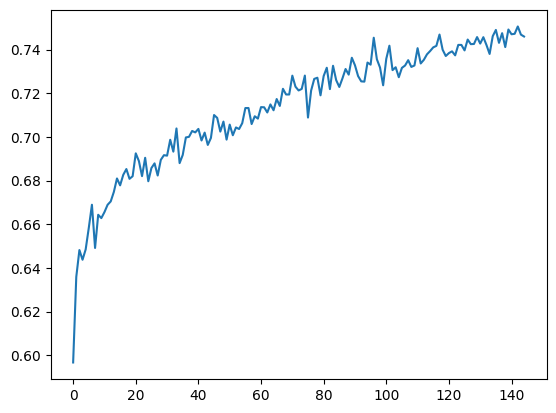

In [132]:
i = -1
j = 1
csi_values = [compute_metrics(x[i])[j] for x in train_losses]
# csi_values = [
#     0.6252, 0.6411, 0.6467, 0.6464, 0.6481, 0.6507, 0.6464, 0.6601, 0.6589, 0.6645,
#     0.6561, 0.6637, 0.6735, 0.6653, 0.6677, 0.6637, 0.6690, 0.6669, 0.6710, 0.6642,
#     0.6676, 0.6734, 0.6701, 0.6670, 0.6628, 0.6713, 0.6857, 0.6701, 0.6793, 0.6815,
#     0.6812, 0.6805, 0.6801, 0.6646, 0.6781, 0.6730, 0.6820, 0.6841, 0.6864, 0.6788,
#     0.6874, 0.6828, 0.6772, 0.6884, 0.6823, 0.6870, 0.6897, 0.6807, 0.6885, 0.6784,
#     0.6908, 0.6717, 0.6866, 0.6778, 0.6868, 0.6941, 0.6838, 0.6813, 0.6891, 0.6762,
#     0.6798, 0.6895, 0.6957, 0.6903, 0.6814, 0.6907, 0.6958, 0.6797, 0.6893, 0.6880,
#     0.6882, 0.6855, 0.6916, 0.6966, 0.6882, 0.6790, 0.6903, 0.6929, 0.6918, 0.6944,
#     0.6887, 0.7093, 0.6971, 0.7010, 0.7006, 0.7073, 0.6933
# ]

# regression_loss_values = [
#     0.0785, 0.0750, 0.0698, 0.0684, 0.0675, 0.0650, 0.0637, 0.0633, 0.0616, 0.0595,
#     0.0589, 0.0583, 0.0591, 0.0592, 0.0592, 0.0572, 0.0574, 0.0572, 0.0551, 0.0554,
#     0.0542, 0.0559, 0.0527, 0.0547, 0.0528, 0.0535, 0.0539, 0.0527, 0.0544, 0.0540,
#     0.0545, 0.0533, 0.0550, 0.0510, 0.0536, 0.0501, 0.0537, 0.0523, 0.0525, 0.0517,
#     0.0519, 0.0504, 0.0512, 0.0520, 0.0510, 0.0513, 0.0512, 0.0506, 0.0505, 0.0490,
#     0.0507, 0.0492, 0.0514, 0.0484, 0.0487, 0.0506, 0.0488, 0.0482, 0.0491, 0.0477,
#     0.0493, 0.0494, 0.0485, 0.0478, 0.0488, 0.0482, 0.0494, 0.0479, 0.0473, 0.0471,
#     0.0478, 0.0498, 0.0472, 0.0468, 0.0480, 0.0494, 0.0480, 0.0476, 0.0481, 0.0478,
#     0.0488, 0.0482, 0.0494, 0.0479, 0.0473, 0.0471, 0.0478, 0.0498, 0.0472, 0.0468,
#     0.0480
# ]

plt.plot(csi_values)

In [ ]:
# Exemple / tracés

images = set_tensor_values2(images, point_measurements)
k=1
plot_images(images[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
            noisy_images[k,...].cpu().numpy(),
            point_measurements[k,...].cpu().numpy(),
            segment_measurements[k,...].cpu().numpy())

In [ ]:
# Tracé output
model.eval()
inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
outputs = model(inputs)
mask_rnr = outputs[:, :nsteps,...] < outputs[:, nsteps:2*nsteps,...]
pred_images = (mask_rnr * outputs[:, 2*nsteps:3*nsteps, ...]).detach()
k=1
plot_images(pred_images[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
            noisy_images[k,...].cpu().numpy(),
            point_measurements[k,...].cpu().numpy(),
            segment_measurements[k,...].cpu().numpy())

In [76]:
import matplotlib.gridspec as gridspec
def plot_images_10pts_20seg(images, noisy_images, point_measurements, segment_measurements):
    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(18, 24))
    gs = gridspec.GridSpec(12, 7, width_ratios=[1, 1, 1, 1, 1, 1, 2])  # Last column twice as wide

    # Manually create axes array for uniform handling as before
    axs = [fig.add_subplot(gs[i, j]) for i in range(12) for j in range(7)]

    # Hide all primary spines and ticks
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)

    # Image and noisy image plots
    for i in range(12):
        image_indices = [5*i, 5*i+1, 5*i+2, 5*i+3, 5*i+4, 5*i]
        noisy_index = i
        for j in range(6):
            ax = axs[i*7 + j]
            img = noisy_images[noisy_index] if j == 5 else images[image_indices[j]]
            # img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect='auto')
            ax.axis('off')

    # Point and Segment measurements plots
    for row in range(12):
        ax_main = axs[row * 7 + 6]  # Last column in each row
        if row < 4:  # First four rows for point measurements
            for idx in range(3) if row in [0,1,2] else range(1):
                ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                ax.plot(point_measurements[2:, idx + row*3], marker='.', markevery=(4, 5), markeredgewidth=2, markeredgecolor='black')
                label = f"Pluvio {idx+1 + row*3}"
                ax.set_ylim([-0.1, 1.5])
                coord1 = f"x={point_measurements[0, idx + row*3]:.2f}"  # First coordinate on a new line
                coord2 = f"y={point_measurements[1, idx + row*3]:.2f}"  # Second coordinate on another new line
                full_label = f"{label}\n{coord1}\n{coord2}"  # Combine into one string with two newlines
                ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                ax.yaxis.set_label_coords(0.05, 0.4)
                ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                for spine in ax.spines.values():
                    spine.set_visible(False)

        elif 4 <= row < 11:  # Next 7 rows for segment measurements
            for idx in range(3) if row in [4,5,6,7,8,9,10] else range(1):
                actual_idx = 3 * (row - 4) + idx
                if actual_idx < 20:  # Ensure we don't exceed the 20 graphs
                    ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                    ax.plot(segment_measurements[4:, actual_idx], marker='.', markevery=(4, 5), markeredgewidth=1, markeredgecolor='black')
                    ax.set_ylim([-0.1, 1.5])
                    label = f"CML {actual_idx+1}"
                    coord_text = f"x1={segment_measurements[0, actual_idx]:.2f}, y1={segment_measurements[1, actual_idx]:.2f}\nx2={segment_measurements[2, actual_idx]:.2f}, y2={segment_measurements[3, actual_idx]:.2f}"
                    full_label = f"{label}\n{coord_text}"
                    ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                    ax.yaxis.set_label_coords(0.05, 0.4)
                    ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                    for spine in ax.spines.values():
                        spine.set_visible(False)
    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.1, wspace=0.05)  # Adjust overall spacing

    plt.tight_layout()
    plt.show()


In [ ]:
mask_rnr = outputs[:, :nsteps,...] < outputs[:, nsteps:2*nsteps,...]
images_pred = (mask_rnr * outputs[:, 2*nsteps:3*nsteps, ...]).detach()
k=1
plot_images_10pts_20seg(3*images_pred[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
            noisy_images[k,...].cpu().numpy(),
            point_measurements[k,...].cpu().numpy(),
            segment_measurements[k,...].cpu().numpy())

In [87]:
def plot_results_10pts_20seg(images, noisy_images, point_measurements, segment_measurements, images_pred, images_pred_5min_mask, point_measurements_pred, segment_measurements_pred):
    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(18, 48))
    gs = gridspec.GridSpec(24, 7, width_ratios=[1, 1, 1, 1, 1, 1, 2])  # Last column twice as wide

    # Manually create axes array for uniform handling as before
    axs = [fig.add_subplot(gs[i, j]) for i in range(24) for j in range(7)]

    # Hide all primary spines and ticks
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)

    # Image and noisy image plots
    for i in range(12):
        image_indices = [5*i, 5*i+1, 5*i+2, 5*i+3, 5*i+4, 5*i]
        noisy_index = i
        for j in range(6):
            ax = axs[i*14 + j]
            img = noisy_images[noisy_index] if j == 5 else images[image_indices[j]]
            img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect='auto')
            ax.axis('off')

    # Outputs and masked output plots
    for i in range(12):
        image_indices = [5*i, 5*i+1, 5*i+2, 5*i+3, 5*i+4, 5*i]
        noisy_index = i
        for j in range(6):
            ax = axs[7 + i*14 + j]
            img = images_pred_5min_mask[noisy_index] if j == 5 else images_pred[image_indices[j]]
            img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect='auto')
            ax.axis('off')

    # Point and Segment measurements plots
    for row in range(12):
        ax_main = axs[row * 7 + 6]  # Last column in each row
        if row < 4:  # First four rows for point measurements
            for idx in range(3) if row in [0,1,2] else range(1):
                ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                ax.plot(point_measurements[2:, idx + row*3], marker='.', markevery=(4, 5), markeredgewidth=2, markeredgecolor='black')
                ax.plot(point_measurements_pred[2:, idx + row*3], marker='.', markevery=(4, 5), markeredgewidth=2, markeredgecolor='black', color='red')
                label = f"Pluvio {idx+1 + row*3}"
                ax.set_ylim([-0.1, 1.5])
                coord1 = f"x={point_measurements[0, idx + row*3]:.2f}"  # First coordinate on a new line
                coord2 = f"y={point_measurements[1, idx + row*3]:.2f}"  # Second coordinate on another new line
                full_label = f"{label}\n{coord1}\n{coord2}"  # Combine into one string with two newlines
                ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                ax.yaxis.set_label_coords(0.05, 0.4)
                ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                for spine in ax.spines.values():
                    spine.set_visible(False)

        elif 4 <= row < 11:  # Next 7 rows for segment measurements
            for idx in range(3) if row in [4,5,6,7,8,9,10] else range(1):
                actual_idx = 3 * (row - 4) + idx
                if actual_idx < 20:  # Ensure we don't exceed the 20 graphs
                    ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                    ax.plot(segment_measurements[4:, actual_idx], marker='.', markevery=(4, 5), markeredgewidth=1, markeredgecolor='black')
                    ax.plot(segment_measurements_pred[4:, actual_idx], marker='.', markevery=(4, 5), markeredgewidth=1, markeredgecolor='black',color='red')
                    ax.set_ylim([-0.1, 1.5])
                    label = f"CML {actual_idx+1}"
                    coord_text = f"x1={segment_measurements[0, actual_idx]:.2f}, y1={segment_measurements[1, actual_idx]:.2f}\nx2={segment_measurements[2, actual_idx]:.2f}, y2={segment_measurements[3, actual_idx]:.2f}"
                    full_label = f"{label}\n{coord_text}"
                    ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                    ax.yaxis.set_label_coords(0.05, 0.4)
                    ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                    for spine in ax.spines.values():
                        spine.set_visible(False)
    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.1, wspace=0.05)  # Adjust overall spacing

    plt.tight_layout()
    plt.show()



def generate_indices_rows_and_columns(images, npoints):
  bs, nsteps, S, _ = images.shape
  weights = torch.ones(S**2).expand(bs, -1).to(images.device)
  indices = torch.multinomial(weights, num_samples=npoints, replacement=False) #.to(images.device)

  # Calculate coordinates from indices
  rows = indices // S
  cols = indices % S

  # Gather the values from these indices for all images
  indices = indices.unsqueeze(dim=1).repeat([1,nsteps,1])
  return indices, rows, cols



def indices_to_sampled_values(images, indices):
  bs, nsteps, S, _ = images.shape
  flat_images = images.view(bs, nsteps, S * S)

  # Gather the values from these indices for all images
  sampled_values = torch.gather(flat_images, 2, indices)
  return sampled_values




def get_point_measurements(rows, cols, sampled_values, S=64):
  # Normalize coordinates to be between 0 and 1
  ys = (1 - rows.float()/S) - 1/(2*S)
  xs = cols.float()/S + 1/(2*S)

  # Stack the normalized coordinates with the values
  point_measurements = torch.cat((xs.unsqueeze(1),
                      ys.unsqueeze(1),
                      sampled_values), dim=1)
  return point_measurements




def point_gt(images, npoints=10, use_fcn=False):
  bs, nsteps, S, _ = images.shape

  indices, rows, cols = generate_indices_rows_and_columns(images, npoints)

  sampled_values = indices_to_sampled_values(images, indices)
  point_measurements = get_point_measurements(rows, cols, sampled_values, S)

  if not use_fcn:
    return point_measurements, None, (indices, rows, cols)

  else:
    # Difference with point_gt:
    point_measurements_fcn = -0.1 * torch.ones(images.numel(), device=images.device)
    indices_batch = torch.arange(bs).repeat(60)
    # indice du premier élément de la i ème image pour le premier time step dans images.flatten()
    idx_i000=(torch.arange(bs, device = images.device) * nsteps).view(bs,1).expand(bs,nsteps)
    # indices du premier élément de la i ème image pour le premier time step j dans images.flatten()
    idx_ij00=idx_i000 + torch.arange(nsteps, device = images.device).view(1,nsteps).expand(bs,nsteps)
    # indices à conserver :
    idx_ijkl = S**2 * idx_ij00.unsqueeze(-1) + indices
    point_measurements_fcn[idx_ijkl.flatten()] = sampled_values.flatten()

    point_measurements_fcn = point_measurements_fcn.view(bs, nsteps, S, S)

    return point_measurements, point_measurements_fcn, (indices, rows, cols)

In [133]:
# Tracé output
model.eval()

with torch.no_grad():

  running_regression_loss = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)

  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # generation point and segment measurements
    # segment_measurements = segment_gt(images, pairs, filters)
    segment_measurements, segment_measurements_fcn = segment_gt(images, pairs, filters, use_fcn=use_fcn)

    # pseudo pluvios
    point_measurements, point_measurements_fcn, (indices, rows, cols) = \
                        point_gt(images, npoints=npoints, use_fcn=use_fcn)

    # pseudo radar
    noisy_images = make_noisy_images(images)

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn
    outputs = model(inputs)
    mask_rnr = outputs[:, :nsteps,...] < outputs[:, nsteps:2*nsteps,...]
    images_pred = (mask_rnr * outputs[:, 2*nsteps:3*nsteps, ...]).detach()

    # segment_measurements = segment_gt(images, pairs, filters)
    segment_measurements_pred, _ = segment_gt(images_pred,
                                              pairs,
                                              filters,
                                              use_fcn=use_fcn)

    # pseudo pluvios
    sampled_values_pred = indices_to_sampled_values(images_pred, indices)
    point_measurements_pred = get_point_measurements(rows, cols,
                                                     sampled_values_pred,
                                                     size_image)

    break







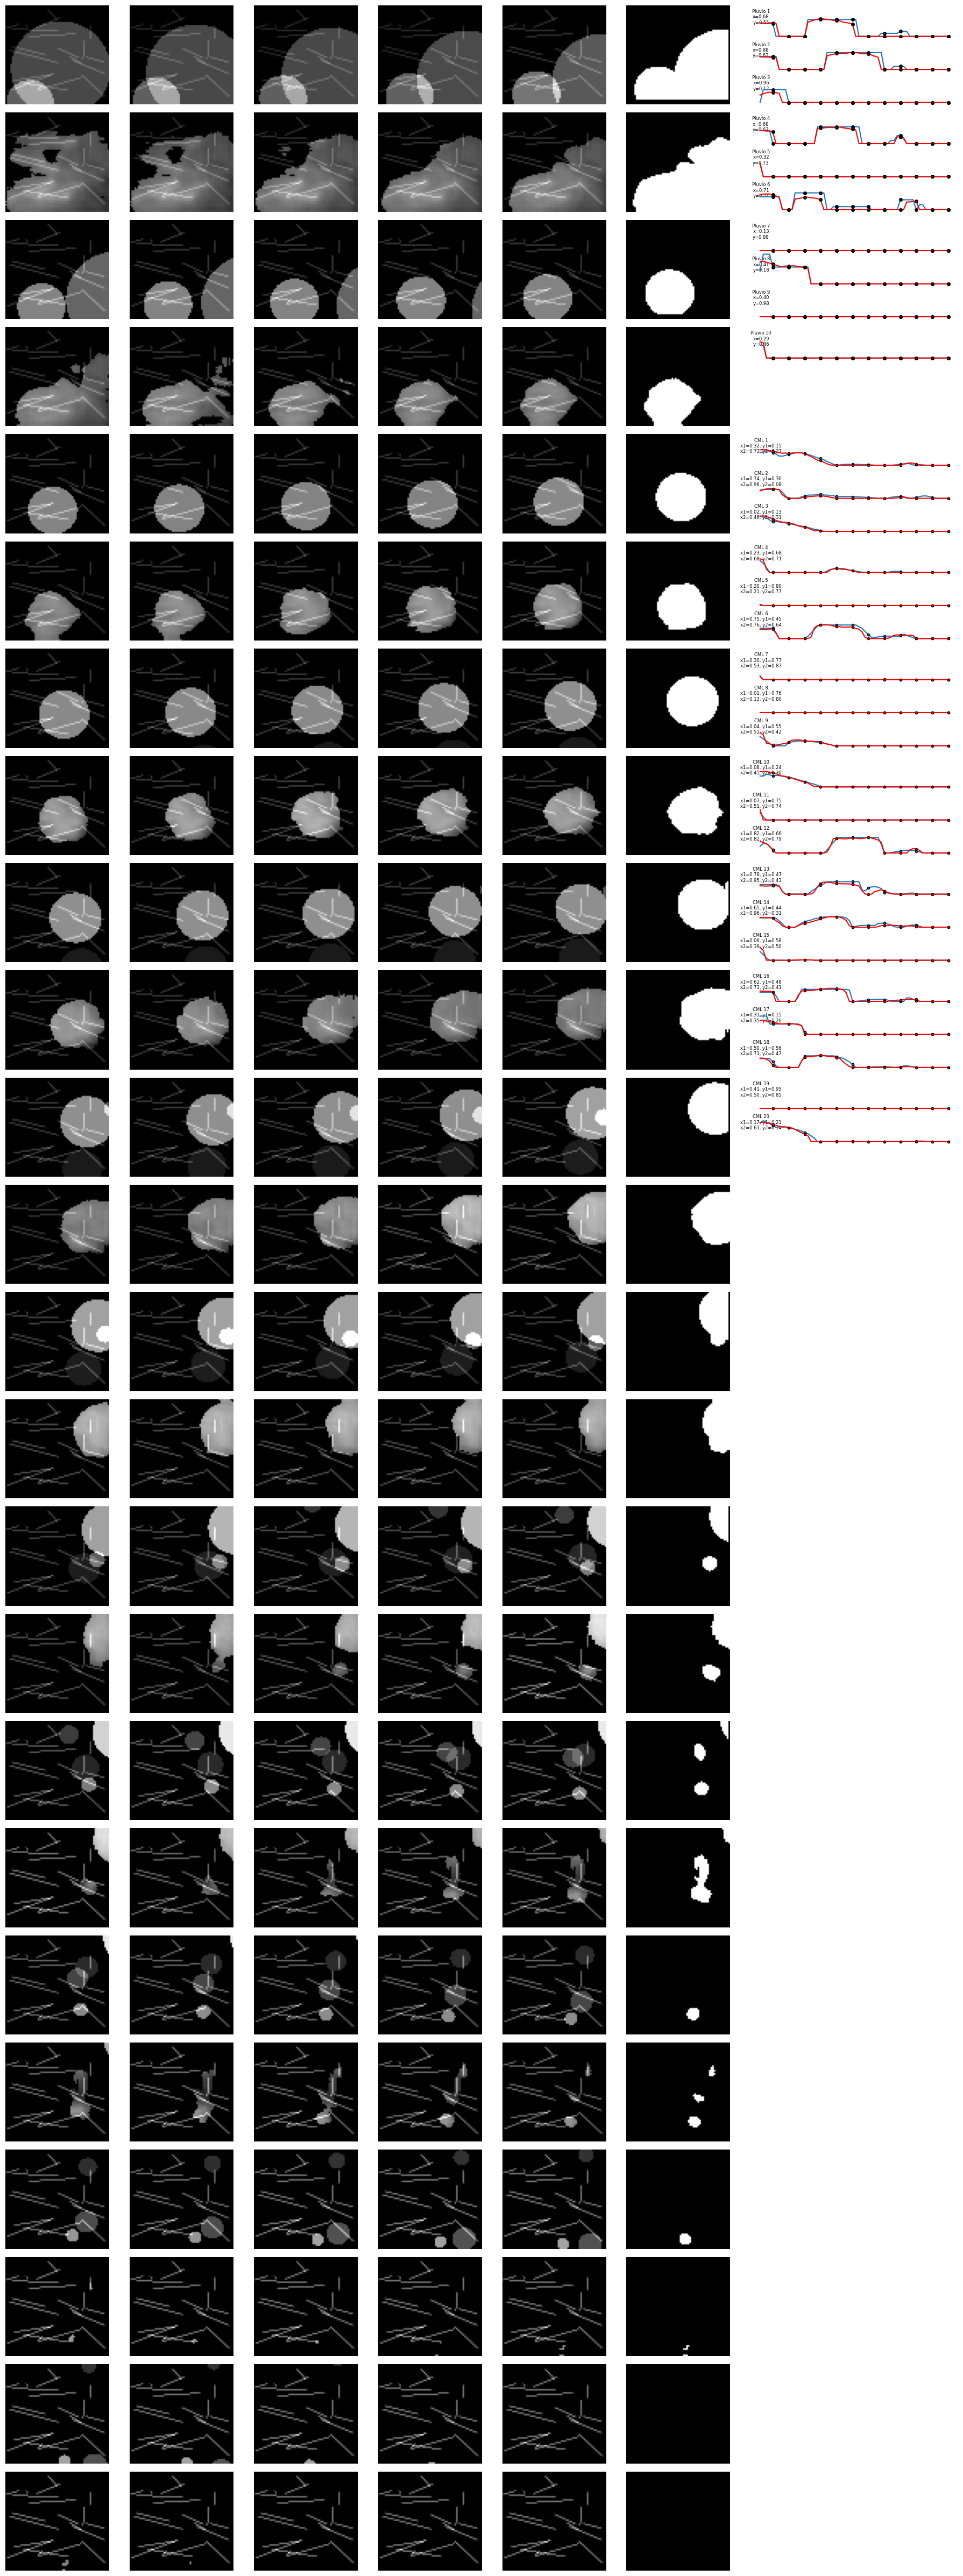

In [134]:
k=0
# plot_images(images[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
#             noisy_images[k,...].cpu().numpy(),
#             point_measurements[k,...].cpu().numpy(),
#             segment_measurements[k,...].cpu().numpy())

plot_results_10pts_20seg(3*images[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
                         noisy_images[k,...].cpu().numpy(),
                         point_measurements[k,...].cpu().numpy(),
                         segment_measurements[k,...].cpu().numpy(),
                         3*images_pred[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
                         (images_pred[k, torch.arange(4, 60, 5), ...] > 0).long().cpu().numpy(),
                         point_measurements_pred[k,...].cpu().numpy(), #_pred,
                         segment_measurements_pred[k,...].cpu().numpy()) #_pred)

In [ ]:
# Archi

# cas d'un "fusion transformer 4d"
# Paramètres du modèle :
image_size = [64,64]
channels = 1
patch_size = 4
d_model = 120
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 4
n_layers = 12


model = FusionTransformer2dplus(image_size, patch_size, n_layers, d_model, d_ff, n_heads, channels=1)


In [ ]:
! pip install einops

#Transformer 2d, time = channels
from utile_Transformers import Block, Decoder
import torch.nn as nn

class UnifiedEmbedding2dplus(nn.Module):
  # le temps ici est compté comme un channel
    def __init__(self, d_model, patch_size, channels, nsteps):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.channels = channels
        self.nsteps = nsteps
        self.dim_modality = 4
        # Positional embedding for coordinates
        self.coord_embed = nn.Linear(2, d_model // 3)

        # Modality specific embeddings
        self.patch_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.point_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.segment_modality = nn.Parameter(torch.randn(self.dim_modality))

        # Feature embedding for radar image patches
        self.patch_feature_embed = nn.Conv2d(channels, d_model - self.dim_modality \
                - 2 * (d_model // 3), kernel_size=patch_size, stride=patch_size)

        # Feature embedding for point and segment rain rates
        self.punctual_rain_rate_embed = nn.Linear(nsteps, d_model - self.dim_modality \
                                                  - 2 * (d_model // 3))
        self.integrated_rain_rate_embed = nn.Linear(nsteps, d_model - self.dim_modality \
                                                   - 2 * (d_model // 3))

    def forward(self, image, points, segments):
        B, C, H, W = image.shape
        device = image.device
        # print("Image shape:", image.shape)

        # Embedding patches
        patch_embeddings = self.patch_feature_embed(image).flatten(2).transpose(1, 2)
        # print("Patch embeddings shape:", patch_embeddings.shape)

        # Create grid for patches
        grid_x, grid_y = torch.meshgrid(torch.arange(0, H, self.patch_size), torch.arange(0, W, self.patch_size), indexing='ij')
        grid_x = grid_x.to(device)
        grid_y = grid_y.to(device)
        upleft = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1).float()
        downright = torch.stack((grid_x.flatten() + self.patch_size, grid_y.flatten() + self.patch_size), dim=-1).float()
        # erreur chatGPT !! patch_pos_embeddings = self.coord_embed(upleft) + self.coord_embed(downright)
        patch_pos_embeddings = torch.cat([self.coord_embed(upleft), self.coord_embed(downright)], dim=-1)
        patch_pos_embeddings = patch_pos_embeddings.repeat(B, 1, 1)
        # print("Patch positional embeddings shape:", patch_pos_embeddings.shape)

        patch_embeddings = torch.cat([patch_embeddings, patch_pos_embeddings, self.patch_modality.unsqueeze(0).expand(B, patch_embeddings.size(1), -1)], dim=-1)
        # print("Final patch embeddings shape:", patch_embeddings.shape)

        # Embedding points
        point_pos_embeddings = self.coord_embed(points[..., :2].float())
        # print("Point positional embeddings shape:", point_pos_embeddings.shape)

        point_feature_embeddings = self.punctual_rain_rate_embed(points[..., 2:].float())
        point_embeddings = torch.cat([point_feature_embeddings, point_pos_embeddings, point_pos_embeddings, self.point_modality.unsqueeze(0).expand(B, points.size(1), -1)], dim=-1)
        # print("Final point embeddings shape:", point_embeddings.shape)

        # Embedding segments
        seg_pos_embeddings0 = self.coord_embed(segments[..., :2].float())
        seg_pos_embeddings1 = self.coord_embed(segments[..., 2:4].float())
        segment_feature_embeddings = self.integrated_rain_rate_embed(segments[..., 4:].float())
        segment_embeddings = torch.cat([segment_feature_embeddings, seg_pos_embeddings0, seg_pos_embeddings1, self.segment_modality.unsqueeze(0).expand(B, segments.size(1), -1)], dim=-1)
        # print("Final segment embeddings shape:", segment_embeddings.shape)

        # Concatenate all embeddings
        embeddings = torch.cat([patch_embeddings, point_embeddings, segment_embeddings], dim=1)

        return embeddings

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

def trunc_normal_(tensor, mean=0, std=1):
    nn.init.trunc_normal_(tensor, mean=mean, std=std)


class FusionTransformer2dplus(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        channels=1,
        nsteps=60
    ):
        super().__init__()
        self.ue = UnifiedEmbedding2dplus(d_model, patch_size, channels, nsteps)
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads


        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for _ in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

        self.apply(init_weights)

        self.decoder = Decoder(patch_size, d_model)

    def forward(self, x, y, z):
        # Embed signal
        x = self.ue(x, y, z)  # (B, N, D)

        # Process through each transformer block
        for block in self.blocks:
            x = block(x)

        # Apply final normalization
        x = self.norm(x)
        x = x[:,:256,:]

        x = self.decoder(x)

        return x


In [ ]:
model = model.to(device)

model(noisy_images, point_measurements, segment_measurements)

RuntimeError: Given groups=1, weight of size [36, 1, 4, 4], expected input[1, 12, 64, 64] to have 1 channels, but got 12 channels instead

In [ ]:
# Exemple / tracés
images = set_tensor_values2(images, point_measurements)
plot_images(images[0,...].cpu().numpy() + filters[0,...].cpu().numpy().sum(axis=0),
            noisy_images[0,...].cpu().numpy(),
            point_measurements[0,...].cpu().numpy(),
            segment_measurements[0,...].cpu().numpy())

tensor(0.1194, device='cuda:0')